#CNN-BiLSTM + Attention

Sudah sampai evaluasi 1, 3, 7 RMSE dan CC

Cara Running Load Model
1. Import
2. Read Data 
3. Split Data
4. Normalisasi pakai Standart Scaler
5. Pisah tanggal untuk forecast day 1, 3, 7.
6. Membuat fungsi sliding window
7. Mengaktifkan fungsi ke X, y
8. Membuat fungsi CC dan Load Model
9. Evaluasi pada Day 1, 3, 7 dengan RMSE dan CC
10. Membuat Dataframe dari Predicted value (y_pred)
11. Visualisasi Day 1, 3, 7


In [1]:
#Step 1
import numpy as np
import joblib
import pandas as pd
import datetime
import tensorflow as tf
import os
import random
import timeit
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
from keras.models import Sequential, Model
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Activation, Flatten, concatenate, Permute, Multiply
from keras import backend as K
from keras.metrics import RootMeanSquaredError,MeanAbsolutePercentageError,MeanAbsoluteError,MeanSquaredError,R2Score

In [2]:
df = pd.read_csv('CO2.csv')

In [3]:
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

In [4]:
df =df.reset_index()
df

,time,C02
0,2023-09-09 14:00:00,555
1,2023-09-09 14:15:00,570
2,2023-09-09 14:30:00,570
3,2023-09-09 14:45:00,570
4,2023-09-09 15:00:00,570
...,...,...
10691,2023-12-29 22:45:00,1050
10692,2023-12-29 23:00:00,1050
10693,2023-12-29 23:15:00,1050
10694,2023-12-29 23:30:00,1065


In [5]:
#Step 3
# Split the data into training, validation, and test sets
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_data = df[:n_train].drop(columns=['time']).values
train_date = df[:n_train].drop(columns=['C02'])

val_data   = df[n_train:n_train+n_val].drop(columns=['time']).values
val_date   = df[n_train:n_train+n_val].drop(columns=['C02'])

test_data  = df[-n_test:].drop(columns=['time']).values
test_date  = df[-n_test:].drop(columns=['C02'])

In [6]:
test_date

,time
9625,2023-12-18 20:15:00
9626,2023-12-18 20:30:00
9627,2023-12-18 20:45:00
9628,2023-12-18 21:00:00
9629,2023-12-18 21:15:00
...,...
10691,2023-12-29 22:45:00
10692,2023-12-29 23:00:00
10693,2023-12-29 23:15:00
10694,2023-12-29 23:30:00


In [7]:
print('Train Set      : ',len(train_data))
print('Validation Set : ',len(val_data))
print('Test Set       : ',len(test_data))

Train Set      :  8556
Validation Set :  1069
Test Set       :  1071


In [8]:
#Step 4
# Normalize the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
val_data   = scaler.transform(val_data)
test_data  = scaler.transform(test_data)

In [9]:
#Step 5
#Take day for predict from data test, 48 = 1 day

one_day_date = test_date.head(96)
one_day_data = test_data[:96]

three_day_date = test_date.head(192)
three_day_data = test_data[:192]

seven_day_date = test_date.head(288)
seven_day_data = test_data[:288]

In [10]:
#Step 6 
#Create a windowed dataset for training
window_size = 192 # use 48 from interval one day of data for each window
def create_window_dataset(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [11]:
train_data

array([[-0.58872211],
       [-0.50014151],
       [-0.50014151],
       ...,
       [-0.50014151],
       [-0.41156091],
       [-0.41156091]])

In [12]:
original_data = scaler.inverse_transform(train_data)
original_data

array([[555.],
       [570.],
       [570.],
       ...,
       [570.],
       [585.],
       [585.]])

In [13]:
#Step 7
X_train, y_train = create_window_dataset(train_data, window_size)
X_val, y_val     = create_window_dataset(val_data, window_size)
X_test, y_test   = create_window_dataset(test_data, window_size)

In [14]:
#Step 8a
def cc(y_true, y_pred):
    """
    Compute the correlation coefficient between y_true and y_pred.
    """
    # Compute the covariance matrix
    cov = tfp.stats.covariance(y_true, y_pred, sample_axis=0)

    # Compute the standard deviation of y_true and y_pred
    std_true = tf.keras.backend.std(y_true)
    std_pred = tf.keras.backend.std(y_pred)

    # Compute the correlation coefficient
    return cov / (std_true * std_pred)

In [15]:
#Step 8b
from keras.layers import Layer

class Attention(Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        logits = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(logits, axis=1)
        weighted_inputs = inputs * attention_weights
        if self.return_sequences:
            return weighted_inputs
        else:
            return tf.reduce_sum(weighted_inputs, axis=1)

In [16]:
#Step 8c
from keras.models import load_model
import pickle
#
# # Load the trained model
# model = load_model('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Final.h5', custom_objects={"cc": cc, "Attention": Attention})
#
# # Load the history object
# with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Final.pkl', 'rb') as f:
#     history = pickle.load(f)

In [17]:
input_shape = (window_size, 1)

model = Sequential([
    Conv1D(filters=8, kernel_size=1, activation='relu', input_shape=input_shape),
    Conv1D(filters=8, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Attention(),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1)
])


D:\Users\Desktop\python\原样\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [18]:
#Compile Model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer= optimizer, 
              loss=tf.keras.losses.Huber(), 
              metrics= [RootMeanSquaredError(), cc,MeanAbsolutePercentageError(),MeanAbsoluteError(),MeanSquaredError(),R2Score()])

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, verbose=1,
                               mode='min', 
                               restore_best_weights=True)

In [20]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    validation_data=(X_val, y_val))

Epoch 1/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - cc: 0.4781 - loss: 0.4358 - mean_absolute_error: 0.8204 - mean_absolute_percentage_error: 98.5054 - mean_squared_error: 1.0210 - r2_score: -0.0127 - root_mean_squared_error: 1.0104 - val_cc: 0.4126 - val_loss: 2.0054 - val_mean_absolute_error: 2.4930 - val_mean_absolute_percentage_error: 113.9299 - val_mean_squared_error: 7.0991 - val_r2_score: -6.9459 - val_root_mean_squared_error: 2.6644
Epoch 2/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - cc: 0.4921 - loss: 0.4368 - mean_absolute_error: 0.8115 - mean_absolute_percentage_error: 98.8140 - mean_squared_error: 1.0438 - r2_score: -0.0241 - root_mean_squared_error: 1.0216 - val_cc: 0.4114 - val_loss: 1.9969 - val_mean_absolute_error: 2.4842 - val_mean_absolute_percentage_error: 113.0733 - val_mean_squared_error: 7.0547 - val_r2_score: -6.8962 - val_root_mean_squared_error: 2.6561
Epoch 3/100
523/523 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - cc: 0.5424 - loss: 0.4498 - mean_absolute_e

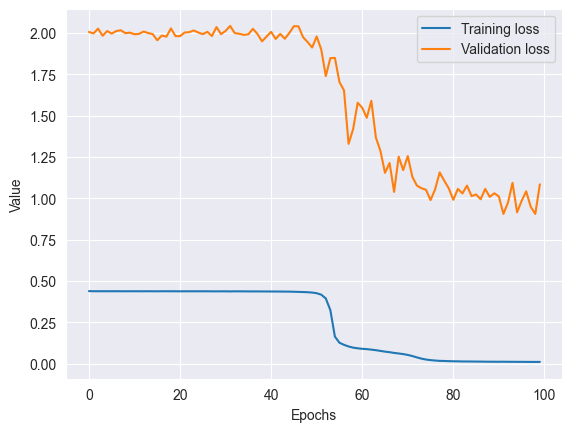

In [21]:
# Plot the training and validation metrics
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

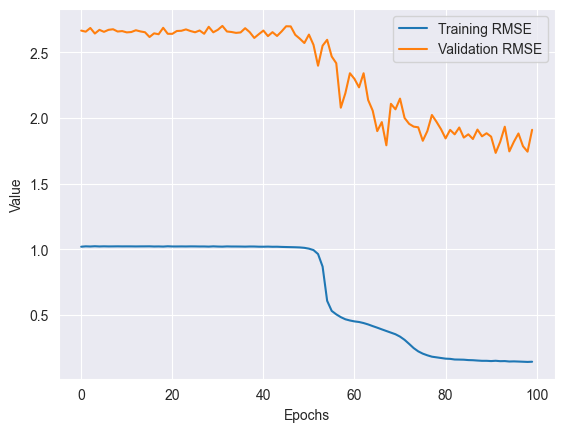

In [22]:
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [23]:
hh = history.history['val_root_mean_squared_error']
hh = pd.DataFrame(hh)
hh

,0
0,2.664412
1,2.656067
2,2.684250
3,2.641964
4,2.670098
...,...
95,1.818054
96,1.881034
97,1.783977
98,1.742653


In [24]:
hh['val_root_mean_squared_error'] = history.history['val_root_mean_squared_error']
hh['root_mean_squared_error'] = history.history['root_mean_squared_error']
hh

,0,val_root_mean_squared_error,root_mean_squared_error
0,2.664412,2.664412,1.018893
1,2.656067,2.656067,1.021740
2,2.684250,2.684250,1.020589
3,2.641964,2.641964,1.022512
4,2.670098,2.670098,1.020845
...,...,...,...
95,1.818054,1.818054,0.145903
96,1.881034,1.881034,0.144610
97,1.783977,1.783977,0.143233
98,1.742653,1.742653,0.141762


In [ ]:
hh.to_csv("cLa-rmseloss_T48.csv")

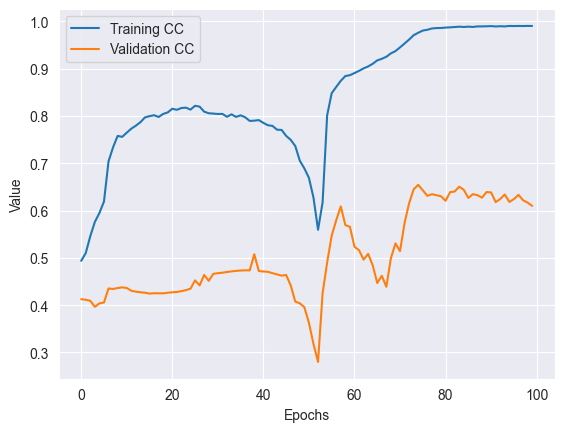

In [25]:
plt.plot(history.history['cc'], label='Training CC')
plt.plot(history.history['val_cc'], label='Validation CC')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
test_cc, test_loss, test_mae ,test_mape,test_mse,test_r2,test_rmse= model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - cc: 0.9722 - loss: 0.0257 - mean_absolute_error: 0.1773 - mean_absolute_percentage_error: 42.4106 - mean_squared_error: 0.0510 - r2_score: 0.7703 - root_mean_squared_error: 0.2166
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


In [27]:
y_pred
YP = scaler.inverse_transform(y_pred)
YP

array([[ 641.2303 ],
       [ 638.08954],
       [ 650.75684],
       [ 647.496  ],
       [ 661.5969 ],
       [ 658.65967],
       [ 656.59424],
       [ 654.05084],
       [ 650.66705],
       [ 664.26294],
       [ 661.3939 ],
       [ 661.0805 ],
       [ 659.3055 ],
       [ 672.70593],
       [ 672.1318 ],
       [ 671.4714 ],
       [ 686.619  ],
       [ 685.04193],
       [ 701.0577 ],
       [ 700.162  ],
       [ 700.09064],
       [ 699.6406 ],
       [ 698.76117],
       [ 715.12634],
       [ 715.02106],
       [ 731.8284 ],
       [ 732.2858 ],
       [ 732.6887 ],
       [ 749.9948 ],
       [ 750.06024],
       [ 751.9488 ],
       [ 752.74005],
       [ 770.4009 ],
       [ 771.8239 ],
       [ 773.50806],
       [ 775.9701 ],
       [ 777.1351 ],
       [ 779.7168 ],
       [ 781.3658 ],
       [ 784.63385],
       [ 804.6974 ],
       [ 808.252  ],
       [ 810.5272 ],
       [ 832.41644],
       [ 833.6432 ],
       [ 836.7884 ],
       [ 838.4079 ],
       [ 840.

In [28]:
df = pd.DataFrame(YP)
df

,0
0,641.230286
1,638.089539
2,650.756836
3,647.495972
4,661.596924
...,...
874,970.926147
875,971.285034
876,971.731689
877,970.067444


In [29]:
df.to_csv("CNN-BiLstm-attention-T48.csv")

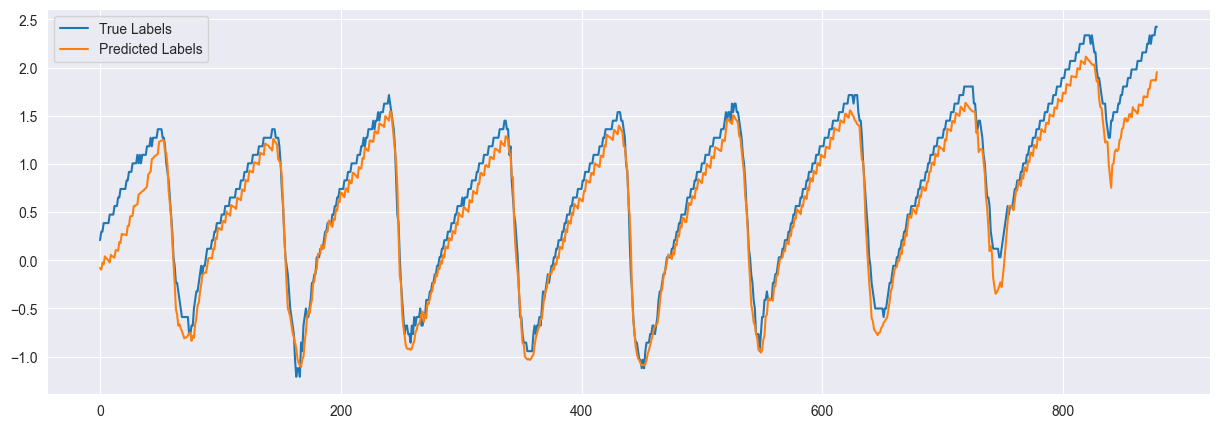

In [30]:
# Plot the predicted and true labels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Labels')
plt.plot(y_pred, label='Predicted Labels')
plt.legend()
plt.show()

In [33]:
#Step 9
#Evaluate the model on the 1, 3, 7 Days to Forecast
X_one   = X_test[:96]
X_three = X_test[:192]
X_seven = X_test[:288]

y_one   = y_test[:96]
y_three = y_test[:192]
y_seven = y_test[:288]

print("1 Day to Forecast")
test_cc, test_loss, test_mae ,test_mape,test_mse,test_r2,test_rmse = model.evaluate(X_one, y_one)
y_pred_one = model.predict(X_one)


print("3 Days to Forecast")
test_cc, test_loss, test_mae ,test_mape,test_mse,test_r2,test_rmse = model.evaluate(X_three, y_three)
y_pred_three = model.predict(X_three)

print("7 Days to Forecast")
test_cc, test_loss, test_mae ,test_mape,test_mse,test_r2,test_rmse = model.evaluate(X_seven, y_seven)
y_pred_seven = model.predict(X_seven)

1 Day to Forecast
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - cc: 0.9613 - loss: 0.0680 - mean_absolute_error: 0.3326 - mean_absolute_percentage_error: 67.7319 - mean_squared_error: 0.1361 - r2_score: -0.2050 - root_mean_squared_error: 0.3644
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3 Days to Forecast
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - cc: 0.9650 - loss: 0.0505 - mean_absolute_error: 0.2684 - mean_absolute_percentage_error: 57.7057 - mean_squared_error: 0.1009 - r2_score: 0.2486 - root_mean_squared_error: 0.3091     
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7 Days to Forecast
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - cc: 0.9670 - loss: 0.0420 - mean_absolute_error: 0.2373 - mean_absolute_percentage_error: 52.4946 - mean_squared_error: 0.0840 - r2_score: 0.4474 - root_mean_squared_error: 0.2797
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [34]:
#Step 10
#Inverse from scaled data
inv_pred_one = scaler.inverse_transform(y_pred_one)
inv_one      = scaler.inverse_transform(y_one)

inv_pred_three = scaler.inverse_transform(y_pred_three)
inv_three      = scaler.inverse_transform(y_three)

inv_pred_seven = scaler.inverse_transform(y_pred_seven)
inv_seven      = scaler.inverse_transform(y_seven)

#Copy data date
viz_one   = one_day_date.copy()
viz_three = three_day_date.copy()
viz_seven = seven_day_date.copy()

#Join true and predicted data
viz_one['load_pred'] = inv_pred_one
viz_one['load_true'] = inv_one

viz_three['load_pred'] = inv_pred_three
viz_three['load_true'] = inv_three

viz_seven['load_pred'] = inv_pred_seven
viz_seven['load_true'] = inv_seven

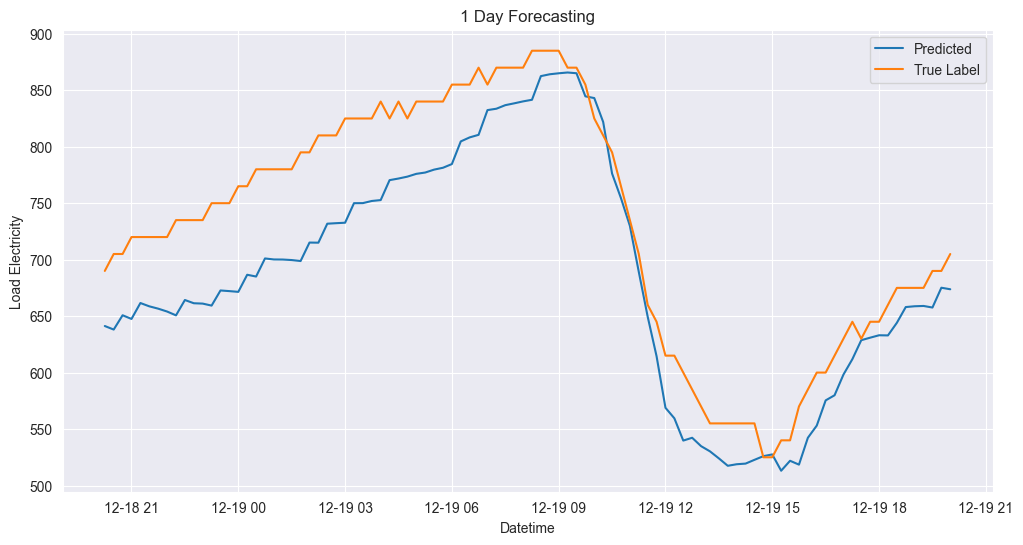

In [35]:

# Load dataset
viz_one = viz_one.set_index('time')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_one.index, viz_one['load_pred'], label='Predicted')
ax.plot(viz_one.index, viz_one['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('1 Day Forecasting')
ax.legend()

# Show plot
plt.show()



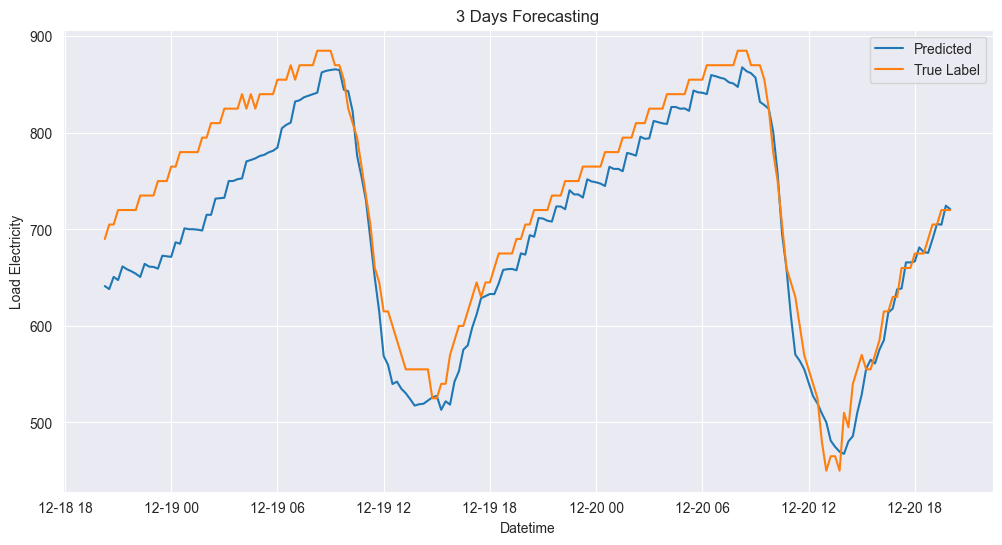

In [36]:
#3 Days Forecasting

# Load dataset
viz_three = viz_three.set_index('time')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_three.index, viz_three['load_pred'], label='Predicted')
ax.plot(viz_three.index, viz_three['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('3 Days Forecasting')
ax.legend()

# Show plot
plt.show()


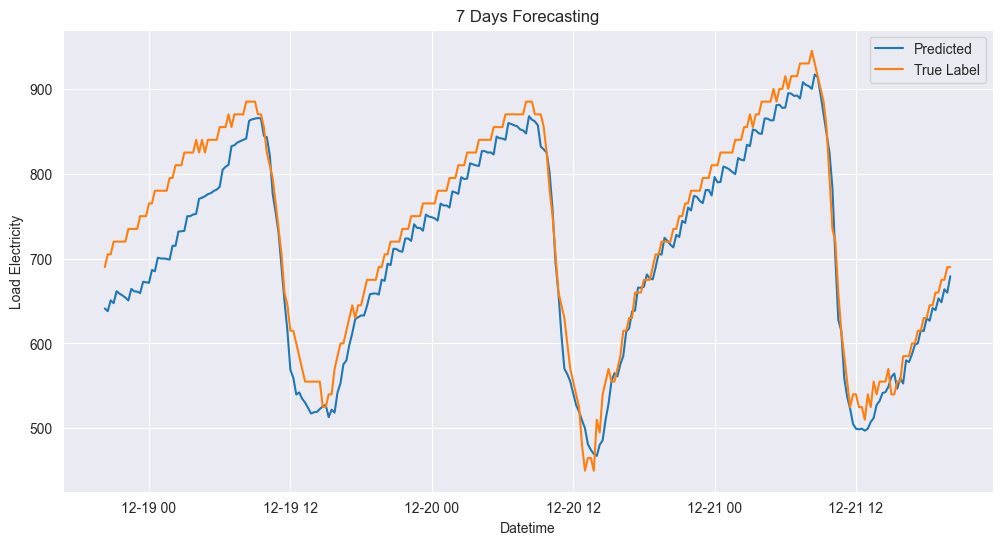

In [37]:
#7 Days Forecasting

# Load dataset
viz_seven = viz_seven.set_index('time')

# Plot two columns in one chart
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(viz_seven.index, viz_seven['load_pred'], label='Predicted')
ax.plot(viz_seven.index, viz_seven['load_true'], label='True Label')

# Add labels and legend
ax.set_xlabel('Datetime')
ax.set_ylabel('Load Electricity')
ax.set_title('7 Days Forecasting')
ax.legend()

# Show plot
plt.show()


In [38]:
# import pickle
#
# # Save the trained model
# model.save('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_Model_Final.h5')
#
# # Save the history object
# with open('/content/drive/MyDrive/Model/CNN-BiLSTM-Attention_history_Final.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 192, 8)         │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 192, 8)         │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 96, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 96, 128)        │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 96, 128)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,571 (549.11 KB)

 Trainable params: 140,569 (549.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

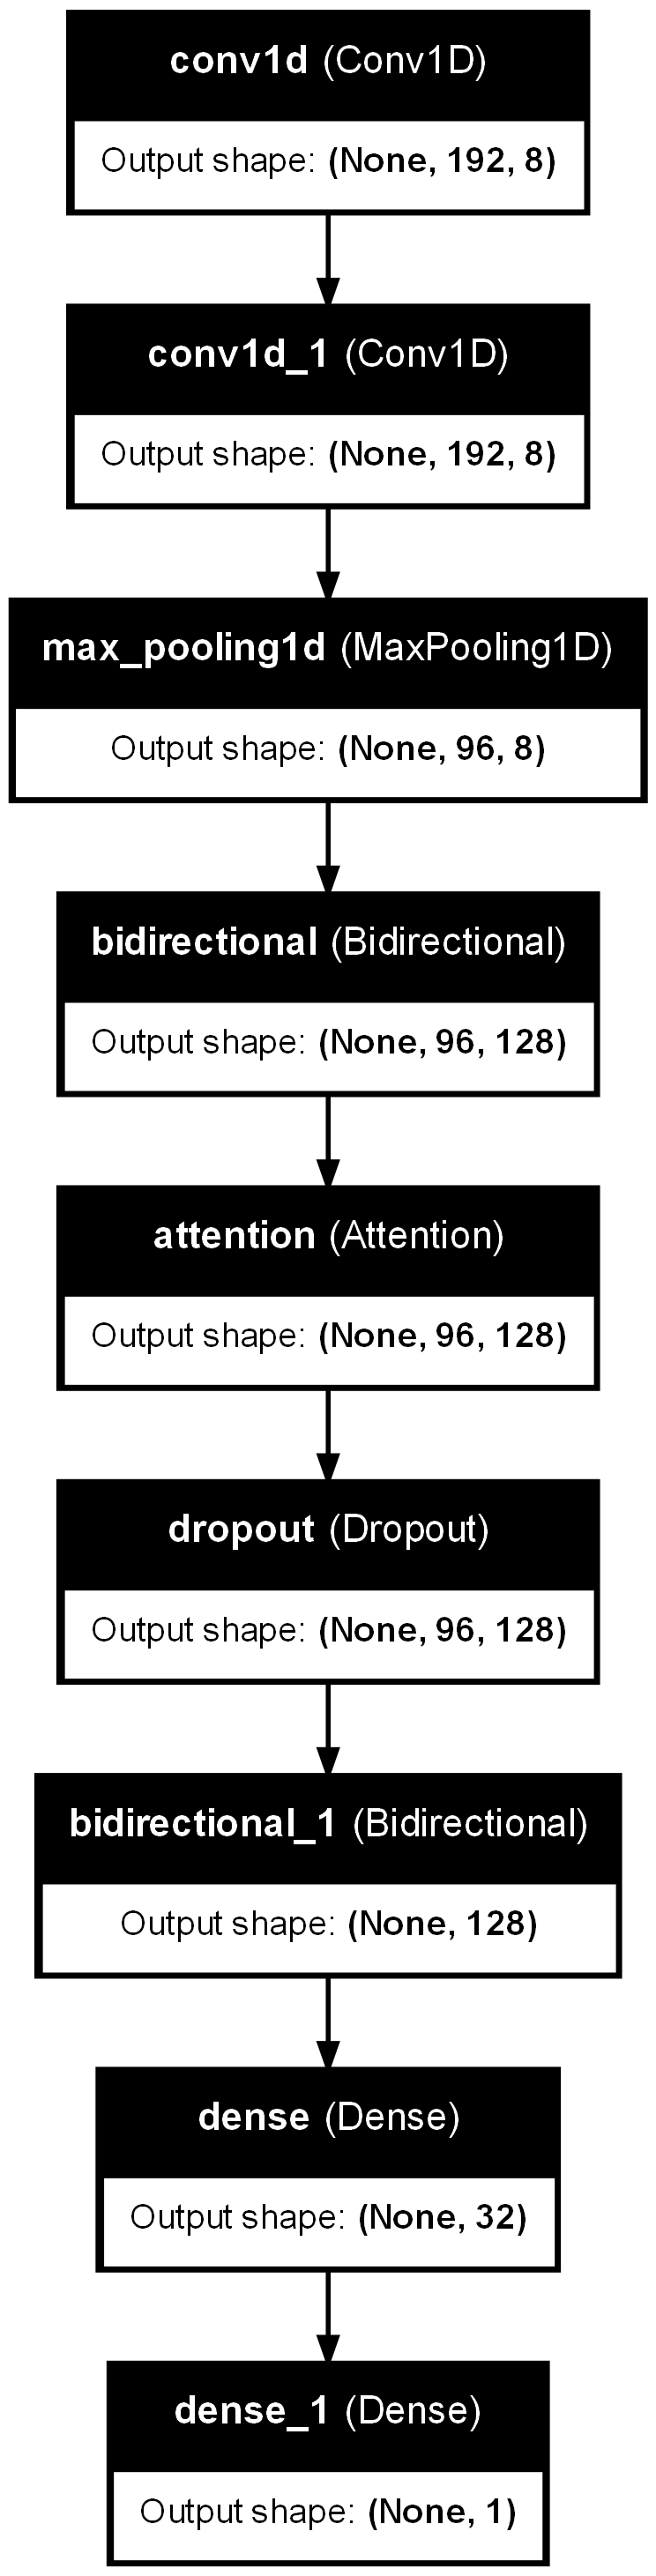

In [40]:
from keras.src.utils.model_visualization import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Use Model To Forecasting

Load Library, Model, and Addition First

In [41]:
#1. Merge array data for base predict
x_data = np.vstack((X_train, X_val, X_test))
x_data

array([[[-0.58872211],
        [-0.50014151],
        [-0.50014151],
        ...,
        [-0.50014151],
        [-0.50014151],
        [-0.41156091]],

       [[-0.50014151],
        [-0.50014151],
        [-0.50014151],
        ...,
        [-0.50014151],
        [-0.41156091],
        [-0.58872211]],

       [[-0.50014151],
        [-0.50014151],
        [-0.50014151],
        ...,
        [-0.41156091],
        [-0.58872211],
        [-0.58872211]],

       ...,

       [[ 0.82856751],
        [ 0.82856751],
        [ 0.91714811],
        ...,
        [ 2.24585713],
        [ 2.33443773],
        [ 2.33443773]],

       [[ 0.82856751],
        [ 0.91714811],
        [ 0.91714811],
        ...,
        [ 2.33443773],
        [ 2.33443773],
        [ 2.33443773]],

       [[ 0.91714811],
        [ 0.91714811],
        [ 1.00572871],
        ...,
        [ 2.33443773],
        [ 2.33443773],
        [ 2.42301833]]])

In [42]:
len(val_data)

1069

In [43]:
x_data.shape

(10120, 192, 1)

In [48]:
#2. test model prediction
import numpy as np

# Set the window size and n_steps
n_steps = 96*7 # 7 days

# Get the last window_size data points
start_index = len(x_data) - n_steps
n_step = x_data[start_index:]

# Make the predictions
y_pred = model.predict(n_step)

# Print the predicted values
print(y_pred)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
[[ 0.8352433 ]
 [ 0.79852045]
 [ 0.800809  ]
 [ 0.9084455 ]
 [ 0.90023506]
 [ 0.8880299 ]
 [ 0.87057984]
 [ 0.8554908 ]
 [ 0.96687686]
 [ 0.95537114]
 [ 0.95090085]
 [ 1.0600312 ]
 [ 1.0500271 ]
 [ 1.1665977 ]
 [ 1.1593933 ]
 [ 1.1395264 ]
 [ 1.1353521 ]
 [ 1.2430824 ]
 [ 1.2417326 ]
 [ 1.2291898 ]
 [ 1.2302811 ]
 [ 1.3355008 ]
 [ 1.3384643 ]
 [ 1.3162297 ]
 [ 1.3187903 ]
 [ 1.4191923 ]
 [ 1.4158266 ]
 [ 1.3997843 ]
 [ 1.4024472 ]
 [ 1.3818727 ]
 [ 1.4955579 ]
 [ 1.476264  ]
 [ 1.4680842 ]
 [ 1.4486654 ]
 [ 1.5491462 ]
 [ 1.5302556 ]
 [ 1.406761  ]
 [ 1.2732463 ]
 [ 1.1368457 ]
 [ 1.005391  ]
 [ 0.7612026 ]
 [ 0.27183124]
 [-0.15796664]
 [-0.23514023]
 [-0.5607671 ]
 [-0.6936952 ]
 [-0.77617705]
 [-0.88334394]
 [-0.9165568 ]
 [-0.9207873 ]
 [-0.9163103 ]
 [-0.929865  ]
 [-0.9162868 ]
 [-0.869928  ]
 [-0.8413044 ]
 [-0.7513796 ]
 [-0.72375476]
 [-0.66845995]
 [-0.6617362 ]
 [-0.624366  ]
 [-0.55593204]
 [-0.5322722 ]
 [-0.63757175]
 [-0.56458175]


In [49]:
#3. Invers to original data
inv_data = scaler.inverse_transform(y_pred)
inv_data

array([[ 796.1305 ],
       [ 789.9119 ],
       [ 790.29944],
       [ 808.5263 ],
       [ 807.136  ],
       [ 805.0692 ],
       [ 802.11426],
       [ 799.55914],
       [ 818.42096],
       [ 816.4726 ],
       [ 815.7156 ],
       [ 834.19543],
       [ 832.5014 ],
       [ 852.24115],
       [ 851.0212 ],
       [ 847.6569 ],
       [ 846.9501 ],
       [ 865.1928 ],
       [ 864.9643 ],
       [ 862.8403 ],
       [ 863.0251 ],
       [ 880.8427 ],
       [ 881.34454],
       [ 877.5794 ],
       [ 878.013  ],
       [ 895.01483],
       [ 894.4449 ],
       [ 891.72833],
       [ 892.17926],
       [ 888.6952 ],
       [ 907.94635],
       [ 904.6792 ],
       [ 903.29407],
       [ 900.0057 ],
       [ 917.0209 ],
       [ 913.82196],
       [ 892.9097 ],
       [ 870.3007 ],
       [ 847.203  ],
       [ 824.9428 ],
       [ 783.5926 ],
       [ 700.72375],
       [ 627.943  ],
       [ 614.8746 ],
       [ 559.7338 ],
       [ 537.2241 ],
       [ 523.2569 ],
       [ 505.

In [46]:
#4. Copy Dataframe
viz = df.copy()
viz

,0
0,641.230286
1,638.089539
2,650.756836
3,647.495972
4,661.596924
...,...
874,970.926147
875,971.285034
876,971.731689
877,970.067444


In [47]:
#5. Generate new forecasting date
from prophet import Prophet
m = Prophet()

viz = viz.rename(columns={'datetime': 'ds', 'load' : 'y'})

m.fit(viz)
future = m.make_future_dataframe(periods=n_steps, freq='30 min', include_history=False)
future

Importing plotly failed. Interactive plots will not work.


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
#6. Merge Forecasting Date and Data
future['load'] = inv_data
future = future.rename(columns={'ds': 'datetime'})
future

In [ ]:
#7. Copy historical data for Visualization
history_predict = n_steps #Set by window_size, 48 = 1 Day

hist_data = df.copy()
hist_data

start_index = len(hist_data) - history_predict
hist_data = hist_data[start_index:]

In [ ]:
len(hist_data)

In [ ]:
hist_data.tail(50)

In [ ]:
#8. Set Index
hist_data = hist_data.set_index('datetime')
future_data = future.set_index('datetime')

In [ ]:
future_data

In [ ]:
#9. Visualization

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
hist_data.plot(ax=ax, label='Training Data', title='Observed Data')
future_data.plot(ax=ax, label='Predicted')
ax.axvline('2020-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Predicted'])
plt.show()